# Predict the Song's Popularity on Spotify

In [1]:
# Importing all the Required Libraries

import pandas as pd
import numpy as np
from numpy import mean, std
import datetime as dt
import pickle
import math

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
init_notebook_mode(connected=True)

In [2]:
# Read and extract from the dataset.

df=pd.read_csv('spotify_top_songs.csv')

In [3]:
df.head()

artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   
3          78         0.551   0.913    0    -4.063     0       0.0466   
4          65         0.614   0.928    8    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018    0.3550    0.894   95.053           pop  
1        0.0103          0.000000    0.6120    0.684  148.726     rock, pop  
2        0.1730          0.000000    0.2510    0.278  136.859  pop, country  
3        0.0263          0.000013    0.3470    0.544  119.992   rock, metal  
4        0.0408          0.001040    0.0845    0.879  172.656           pop

In [4]:
# df[df.duplicated()].count()
df.drop_duplicates(inplace=True)

In [5]:
# df = df[(df['popularity'] > 0)]
# df.loc[df['popularity'] < 10, 'popularity'] = round(df['popularity'].median())

In [6]:
# Shape of the data

df.shape

(1941, 18)

In [7]:
df.loc[(df['genre'].str.contains('set()') | (df['genre'].str.contains('easy listening')) 
        | (df['genre'].str.contains('jazz'))), 'genre'] = 'pop'
df.loc[(df['genre'].str.contains('blues') | df['genre'].str.contains('classical')), 'genre'] = 'rock'
df.loc[(df['genre'].str.contains('World/Traditional') 
        | df['genre'].str.contains('Folk/Acoustic')), 'genre'] = 'acoustic folk'
df.loc[(df['genre'].str.contains('R&B') & df['genre'].str.contains('pop')), 'genre'] = 'R&B'
df.loc[(df['genre'].str.contains('hip hop') & df['genre'].str.contains('pop')), 'genre'] = 'hip hop'
df.loc[(df['genre'].str.contains('rock') & df['genre'].str.contains('pop')), 'genre'] = 'rock'
df.loc[(df['genre'].str.contains('rock') & df['genre'].str.contains('metal')), 'genre'] = 'metal'
df.loc[df['genre'].str.contains('R&B'), 'genre'] = 'R&B'
df.loc[df['genre'].str.contains('hip hop'), 'genre'] = 'hip hop'
df.loc[df['genre'].str.contains('country'), 'genre'] = 'country'
df.loc[df['genre'].str.contains('latin'), 'genre'] = 'latin'
df.loc[df['genre'].str.contains('Dance/Electronic'), 'genre'] = 'EDM'

In [8]:
# Data type of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            1941 non-null   object 
 1   song              1941 non-null   object 
 2   duration_ms       1941 non-null   int64  
 3   explicit          1941 non-null   bool   
 4   year              1941 non-null   int64  
 5   popularity        1941 non-null   int64  
 6   danceability      1941 non-null   float64
 7   energy            1941 non-null   float64
 8   key               1941 non-null   int64  
 9   loudness          1941 non-null   float64
 10  mode              1941 non-null   int64  
 11  speechiness       1941 non-null   float64
 12  acousticness      1941 non-null   float64
 13  instrumentalness  1941 non-null   float64
 14  liveness          1941 non-null   float64
 15  valence           1941 non-null   float64
 16  tempo             1941 non-null   float64


In [9]:
# Checking for null values.

df.isnull().sum()

artist              0
song                0
duration_ms         0
explicit            0
year                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

In [10]:
# Checking for unique values.

df.nunique()

artist               835
song                1879
duration_ms         1793
explicit               2
year                  23
popularity            76
danceability         565
energy               580
key                   12
loudness            1671
mode                   2
speechiness          837
acousticness        1208
instrumentalness     772
liveness             783
valence              760
tempo               1831
genre                  9
dtype: int64

In [11]:
# Description of the data

df.describe()

duration_ms         year   popularity  danceability       energy  \
count    1941.000000  1941.000000  1941.000000   1941.000000  1941.000000   
mean   228594.973725  2009.520350    59.633179      0.667814     0.721549   
std     39249.796103     5.875532    21.501053      0.140608     0.152872   
min    113000.000000  1998.000000     0.000000      0.129000     0.054900   
25%    203506.000000  2004.000000    56.000000      0.581000     0.624000   
50%    223186.000000  2010.000000    65.000000      0.676000     0.739000   
75%    247946.000000  2015.000000    73.000000      0.765000     0.840000   
max    484146.000000  2020.000000    89.000000      0.975000     0.999000   

               key     loudness         mode  speechiness  acousticness  \
count  1941.000000  1941.000000  1941.000000  1941.000000   1941.000000   
mean      5.369397    -5.514082     0.553323     0.103783      0.128173   
std       3.615270     1.938950     0.497277     0.096148      0.172584   
min       0.000000   -20.514000     0.000000     0.023200      0.000019   
25%       2.000000    -6.490000     0.000000     0.039700      0.013500   
50%       6.000000    -5.285000     1.000000     0.061000      0.055800   
75%       8.000000    -4.168000     1.000000     0.129000      0.176000   
max      11.000000    -0.276000     1.000000     0.576000      0.976000   

       instrumentalness     liveness      valence        tempo  
count       1941.000000  1941.000000  1941.000000  1941.000000  
mean           0.015372     0.181726     0.552966   120.158442  
std            0.088371     0.140910     0.220845    26.990475  
min            0.000000     0.021500     0.038100    60.019000  
25%            0.000000     0.088400     0.390000    98.986000  
50%            0.000000     0.124000     0.560000   120.028000  
75%            0.000069     0.242000     0.731000   134.199000  
max            0.985000     0.853000     0.973000   210.851000

In [12]:
# Correlation of data features

df.corr()

duration_ms  explicit      year  popularity  danceability  \
duration_ms          1.000000  0.119608 -0.318835    0.048140     -0.060083   
explicit             0.119608  1.000000  0.077361    0.047308      0.243799   
year                -0.318835  0.077361  1.000000   -0.007294      0.035444   
popularity           0.048140  0.047308 -0.007294    1.000000     -0.000143   
danceability        -0.060083  0.243799  0.035444   -0.000143      1.000000   
energy              -0.082982 -0.164212 -0.110265   -0.013404     -0.103204   
key                 -0.001353  0.001795  0.008588    0.013561      0.035747   
loudness            -0.086226 -0.091265  0.017228    0.030441     -0.035638   
mode                -0.004095  0.050653 -0.007208   -0.019430     -0.068643   
speechiness          0.062538  0.415445  0.003146    0.021977      0.140955   
acousticness         0.009960 -0.028032  0.040698    0.022501     -0.062374   
instrumentalness    -0.006409 -0.082605 -0.051490   -0.048104      0.021662   
liveness             0.022549  0.008238 -0.026418   -0.010291     -0.127349   
valence             -0.116423 -0.045397 -0.208410   -0.011012      0.403787   
tempo               -0.033762  0.014650  0.077798    0.011057     -0.169074   

                    energy       key  loudness      mode  speechiness  \
duration_ms      -0.082982 -0.001353 -0.086226 -0.004095     0.062538   
explicit         -0.164212  0.001795 -0.091265  0.050653     0.415445   
year             -0.110265  0.008588  0.017228 -0.007208     0.003146   
popularity       -0.013404  0.013561  0.030441 -0.019430     0.021977   
danceability     -0.103204  0.035747 -0.035638 -0.068643     0.140955   
energy            1.000000 -0.000642  0.651986 -0.044177    -0.058225   
key              -0.000642  1.000000 -0.005229 -0.153319     0.003769   
loudness          0.651986 -0.005229  1.000000 -0.027568    -0.081831   
mode             -0.044177 -0.153319 -0.027568  1.000000     0.002192   
speechiness      -0.058225  0.003769 -0.081831  0.002192     1.000000   
acousticness     -0.447056  0.000719 -0.312079  0.009210     0.002926   
instrumentalness  0.040662 -0.004053 -0.103575 -0.036433    -0.062401   
liveness          0.153922 -0.040827  0.101972  0.028334     0.056532   
valence           0.331756  0.035441  0.228250 -0.080279     0.069247   
tempo             0.152305 -0.009852  0.081655  0.047445     0.063192   

                  acousticness  instrumentalness  liveness   valence     tempo  
duration_ms           0.009960         -0.006409  0.022549 -0.116423 -0.033762  
explicit             -0.028032         -0.082605  0.008238 -0.045397  0.014650  
year                  0.040698         -0.051490 -0.026418 -0.208410  0.077798  
popularity            0.022501         -0.048104 -0.010291 -0.011012  0.011057  
danceability         -0.062374          0.021662 -0.127349  0.403787 -0.169074  
energy               -0.447056          0.040662  0.153922  0.331756  0.152305  
key                   0.000719         -0.004053 -0.040827  0.035441 -0.009852  
loudness             -0.312079         -0.103575  0.101972  0.228250  0.081655  
mode                  0.009210         -0.036433  0.028334 -0.080279  0.047445  
speechiness           0.002926         -0.062401  0.056532  0.069247  0.063192  
acousticness          1.000000         -0.003220 -0.107766 -0.126129 -0.105533  
instrumentalness     -0.003220          1.000000 -0.034818 -0.010660  0.035442  
liveness             -0.107766         -0.034818  1.000000  0.014737  0.027449  
valence              -0.126129         -0.010660  0.014737  1.000000 -0.023973  
tempo                -0.105533          0.035442  0.027449 -0.023973  1.000000

In [13]:
# Heatmap

fig = px.imshow(df.corr(), text_auto=True, height=900, width=900, color_continuous_scale=px.colors.sequential.Greens, 
              aspect='auto', template = 'plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Correlation of Columns</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

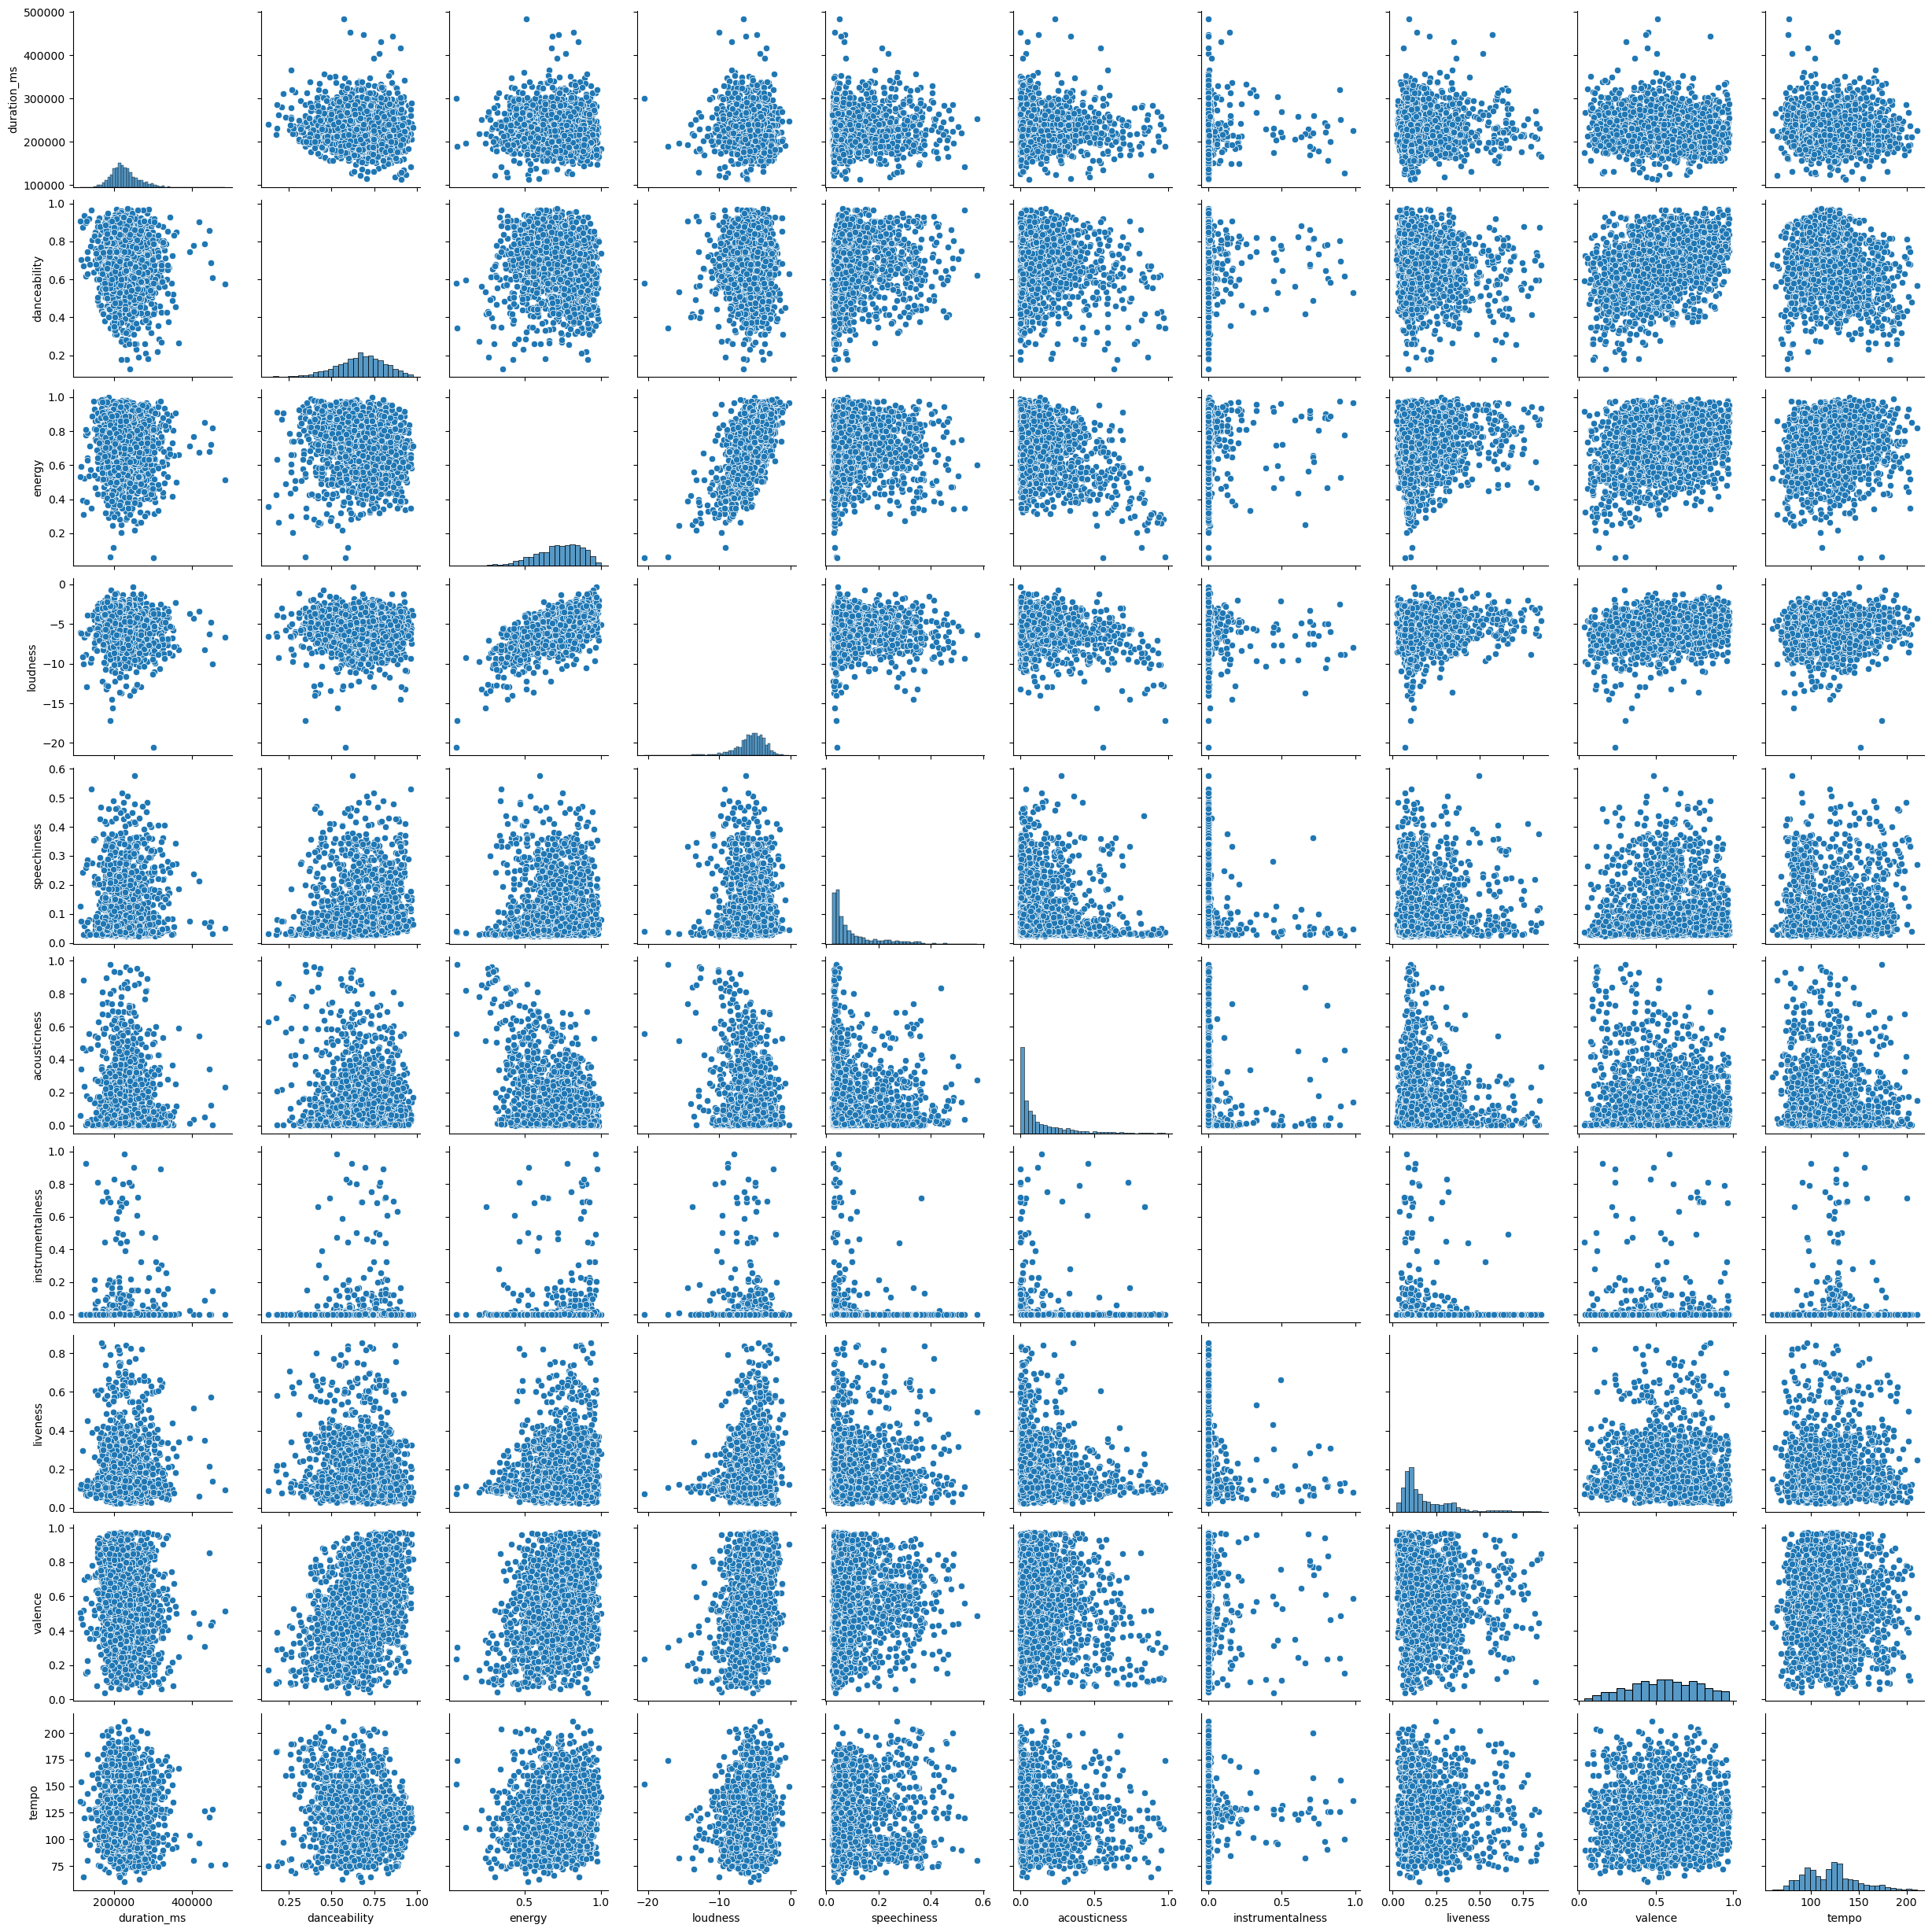

In [14]:
# Scatterplot Matrix

columns = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo']
sns.pairplot(df[columns])
plt.show()

In [15]:
fig = px.treemap(df, path=[px.Constant('Singer'), 'artist', 'genre', 'song'], values='popularity', template = 'plotly_dark')
fig.update_traces(root_color='seagreen', textfont_color='white')
fig.update_layout(title_x=0.5, title={'text':'<b>Tree Map of Singers</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [16]:
popular_songs = df.groupby(['artist'])['popularity'].sum()
popular_df = pd.DataFrame({'Artist': popular_songs.index, 
                           'Popularity': popular_songs.values}).sort_values(by='Popularity', ascending=False)
popular_df

Artist  Popularity
628               Rihanna        1662
239                Eminem        1519
219                 Drake        1424
127         Calvin Harris        1356
118        Britney Spears        1198
..                    ...         ...
685               Silentó           0
152      Childish Gambino           0
785  Two Door Cinema Club           0
363             Jim Jones           0
417                 Kungs           0

[835 rows x 2 columns]

In [17]:
fig = px.bar(df.groupby('artist', as_index=False).sum().sort_values(by='popularity', ascending=False).head(15), 
             x='artist', y='popularity', labels={'popularity':'Popularity', 'artist':'Artist'}, 
             color_discrete_sequence=['limegreen'], text='popularity', template='plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Top 15 Singers</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [18]:
total_songs = df['artist'].value_counts()
songs_df = pd.DataFrame({'Artist': total_songs.index, 'Song': total_songs.values}).sort_values(by='Song', ascending=False)
songs_df

Artist  Song
0             Drake    23
1           Rihanna    23
2            Eminem    21
3     Calvin Harris    20
4    Britney Spears    19
..              ...   ...
494           Sting     1
493    Bomfunk MC's     1
492       Eiffel 65     1
491   Gesaffelstein     1
834    Blanco Brown     1

[835 rows x 2 columns]

In [19]:
fig = px.bar(df.groupby('artist', as_index=False).count().sort_values(by='song', ascending=False).head(50), 
       x='artist', y='song', labels={'song':'Total Songs', 'artist':'Artist'}, color_discrete_sequence=['limegreen'], 
       text='song', template='plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Number of Songs Recorded by Each Singer</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [20]:
genre_popularity = df.groupby(['year', 'genre'])['popularity'].sum().reset_index()
genre_popularity = genre_popularity[(genre_popularity['year'] != 1998) & (genre_popularity['year'] != 2020)]
genre_popularity

year    genre  popularity
1    1999      EDM         171
2    1999      R&B         512
3    1999  country          66
4    1999  hip hop         301
5    1999    latin         110
..    ...      ...         ...
155  2019      R&B         491
156  2019  hip hop        2086
157  2019    latin         526
158  2019      pop        1576
159  2019     rock          65

[159 rows x 3 columns]

In [21]:
fig = px.line(genre_popularity, x='year', y='popularity', color='genre', template='plotly_dark',
             labels={'year':'Year', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b>Popularity of Music Genres Across the Years</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [22]:
genre_counts = df['genre'].value_counts()
genre_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})
genre_df

Genre  Count
0        hip hop    505
1            pop    445
2            R&B    435
3            EDM    258
4           rock    166
5          metal     45
6          latin     43
7  acoustic folk     26
8        country     18

In [23]:
fig = px.pie(genre_df, names='Genre', values='Count', template='plotly_dark', hole=0.4)
fig.update_layout(title_x=0.5, title={'text':'<b>Distribution of Music Genres</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [24]:
fig = px.box(df, x='genre', y='popularity', color='genre', template='plotly_dark', 
             labels={'genre':'Genre', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b> Popular Music Genres</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [25]:
fig=px.pie(df.groupby('explicit', as_index=False).count().sort_values(by='song', ascending=False), names='explicit', 
           values='song', labels={'song':'Total songs', 'explicit':'Explicit'}, hole=.4, 
           color_discrete_sequence=['magenta', 'limegreen'], template='plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Explicit Content in Songs</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [26]:
fig = px.box(df, x='explicit', y='popularity', color='explicit', template='plotly_dark', 
             color_discrete_sequence=['magenta', 'limegreen'], labels={'explicit':'Explicit', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b>Popularity based on explicit content</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

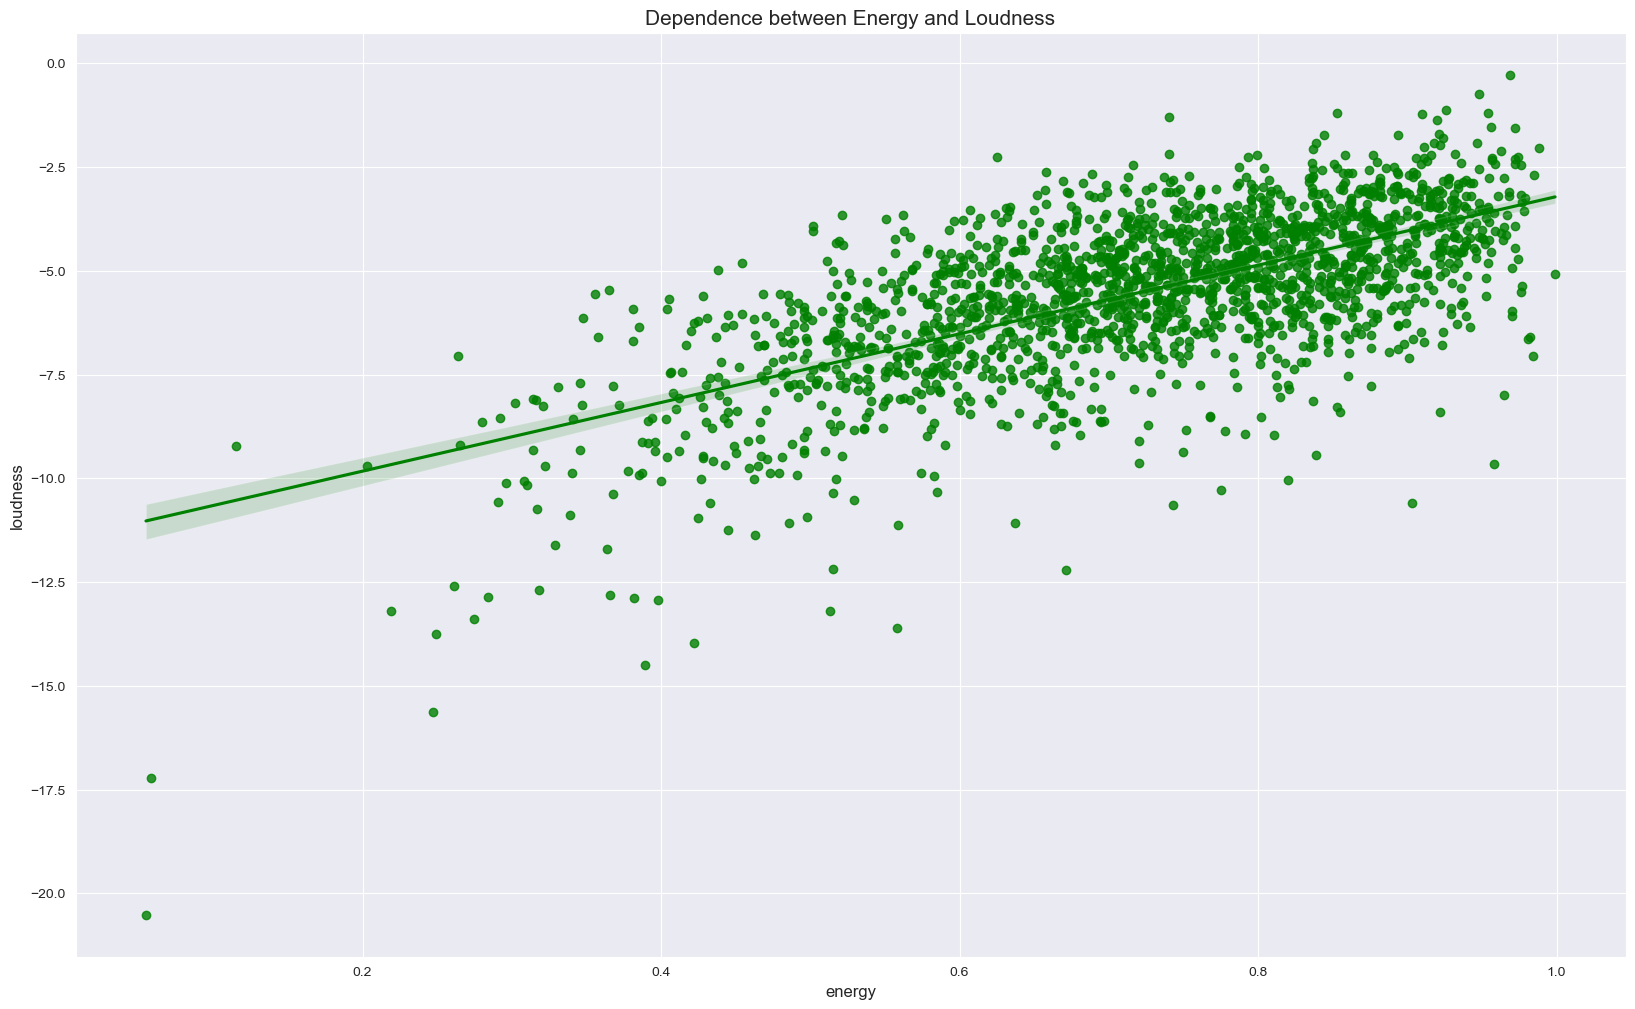

In [27]:
plt.figure(figsize=(20,12))
sns.set_style("darkgrid")
sns.regplot(data=df, x='energy', y='loudness', color='green')
plt.ylabel('loudness', fontsize=12)
plt.xlabel("energy", fontsize=12)
plt.title('Dependence between Energy and Loudness', fontsize=15)
plt.show()

In [28]:
# plt.figure(figsize=(20,12))
# sns.set_style("darkgrid")
# sns.regplot(data=df, x='energy', y='popularity', ci=None, color='green')
# sns.kdeplot(x=df.energy, y=df.popularity, color='red')
# plt.ylabel('popularity', fontsize=12)
# plt.xlabel("energy", fontsize=12)
# plt.title('Dependence between Energy and Popularity', fontsize=15)
# plt.show()

In [29]:
# plt.figure(figsize=(20,12))
# sns.set_style("darkgrid")
# sns.jointplot(data=df, x='tempo', y='popularity', kind="kde", color='green', shade=True, cmap="Greens", height=10)
# plt.ylabel('popularity', fontsize=12)
# plt.xlabel("tempo", fontsize=12)
# plt.title("Tempo (BPM) Vs Popularity", fontsize=15)
# plt.show()

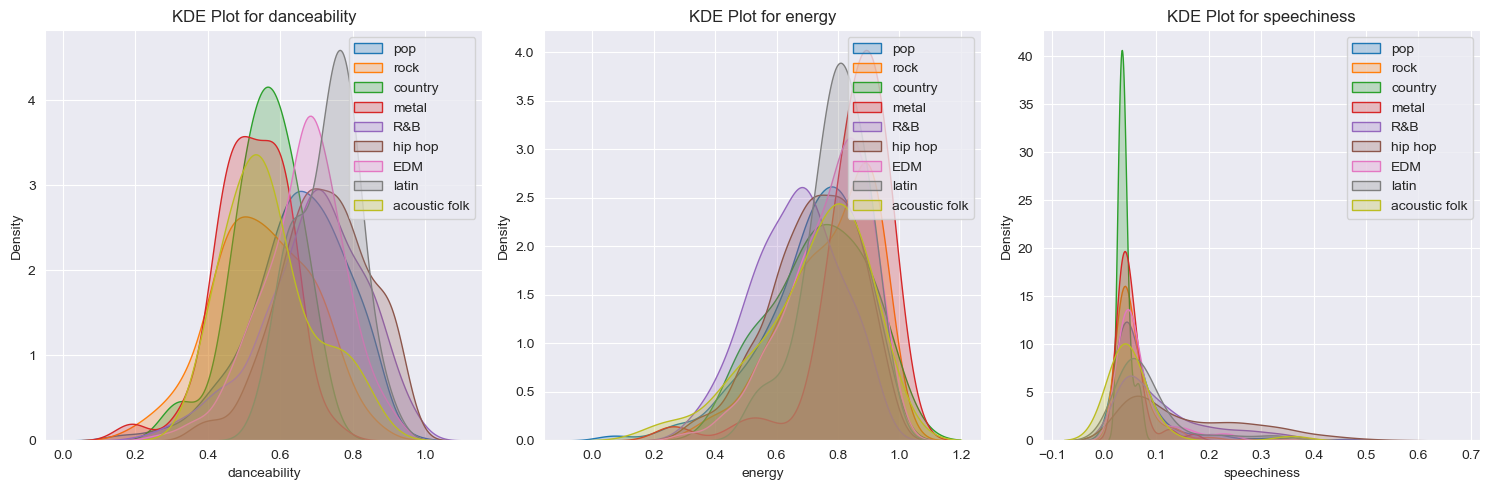

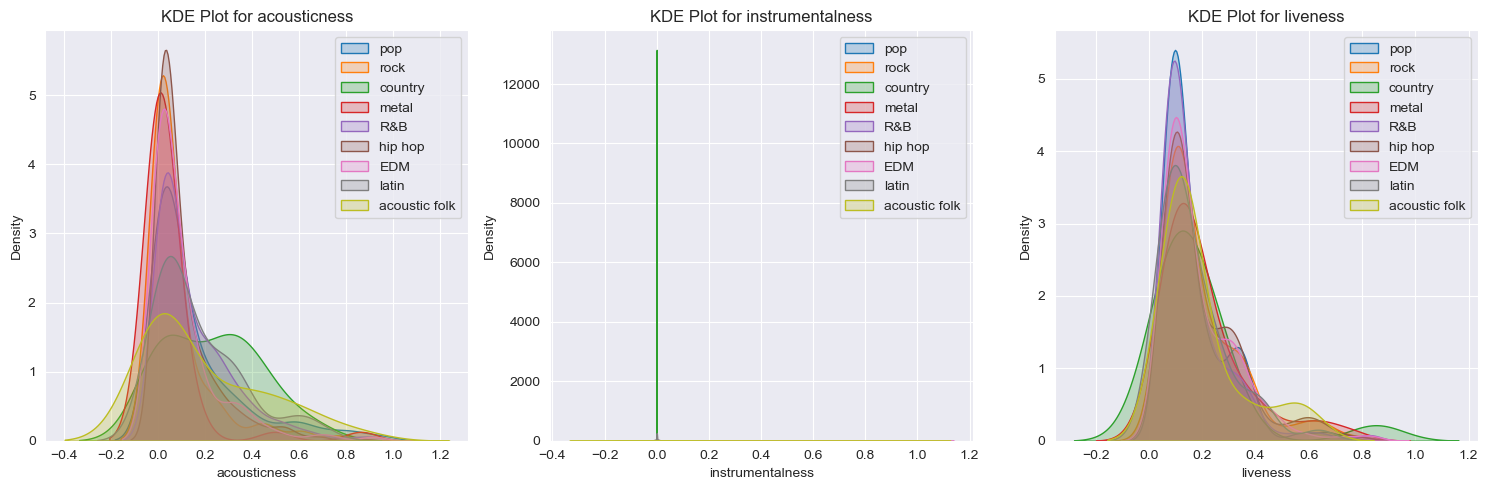

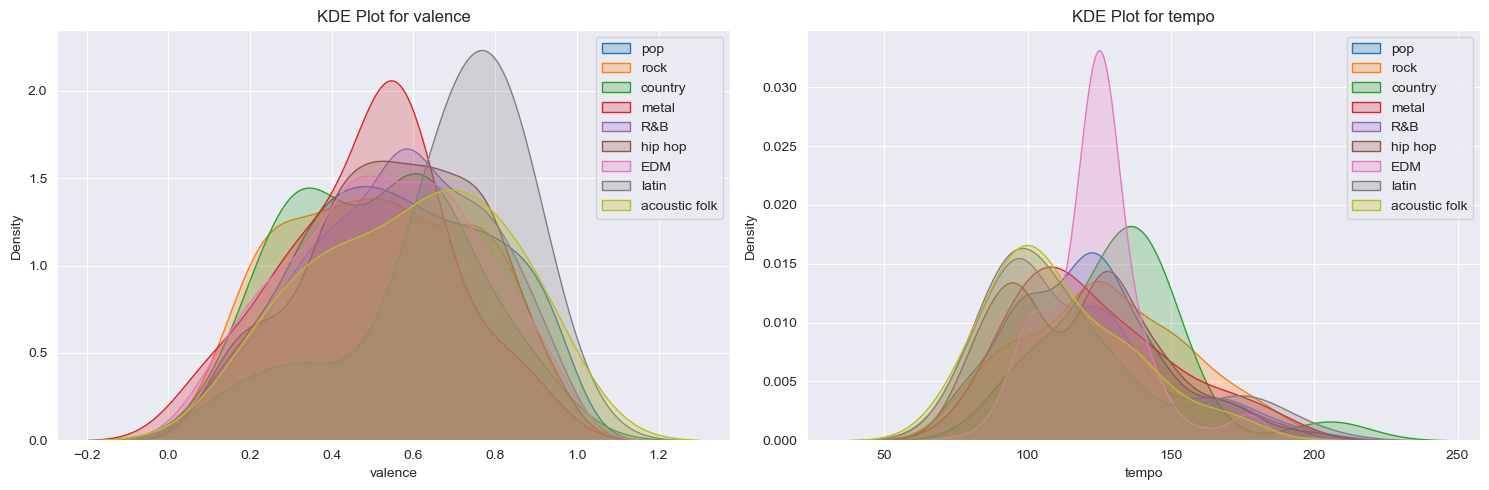

In [30]:
audio_features = ['danceability', 'energy', 'speechiness']

fig, axes = plt.subplots(nrows=1, ncols=len(audio_features), figsize=(15, 5))

for i, feature in enumerate(audio_features):
    for genre in df['genre'].unique():
        subset = df[df['genre'] == genre]
        sns.kdeplot(data=subset, x=feature, ax=axes[i], fill=True, label=genre)

    axes[i].set_title(f'KDE Plot for {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

audio_features = ['acousticness', 'instrumentalness', 'liveness']

fig, axes = plt.subplots(nrows=1, ncols=len(audio_features), figsize=(15, 5))

for i, feature in enumerate(audio_features):
    for genre in df['genre'].unique():
        subset = df[df['genre'] == genre]
        sns.kdeplot(data=subset, x=feature, ax=axes[i], fill=True, label=genre)

    axes[i].set_title(f'KDE Plot for {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

audio_features = ['valence', 'tempo']

fig, axes = plt.subplots(nrows=1, ncols=len(audio_features), figsize=(15, 5))

for i, feature in enumerate(audio_features):
    for genre in df['genre'].unique():
        subset = df[df['genre'] == genre]
        sns.kdeplot(data=subset, x=feature, ax=axes[i], fill=True, label=genre)

    axes[i].set_title(f'KDE Plot for {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# plt.figure(figsize=(15, 5))
# sns.kdeplot(data=df, x='valence', hue='genre' )
# plt.tight_layout()
# plt.show()

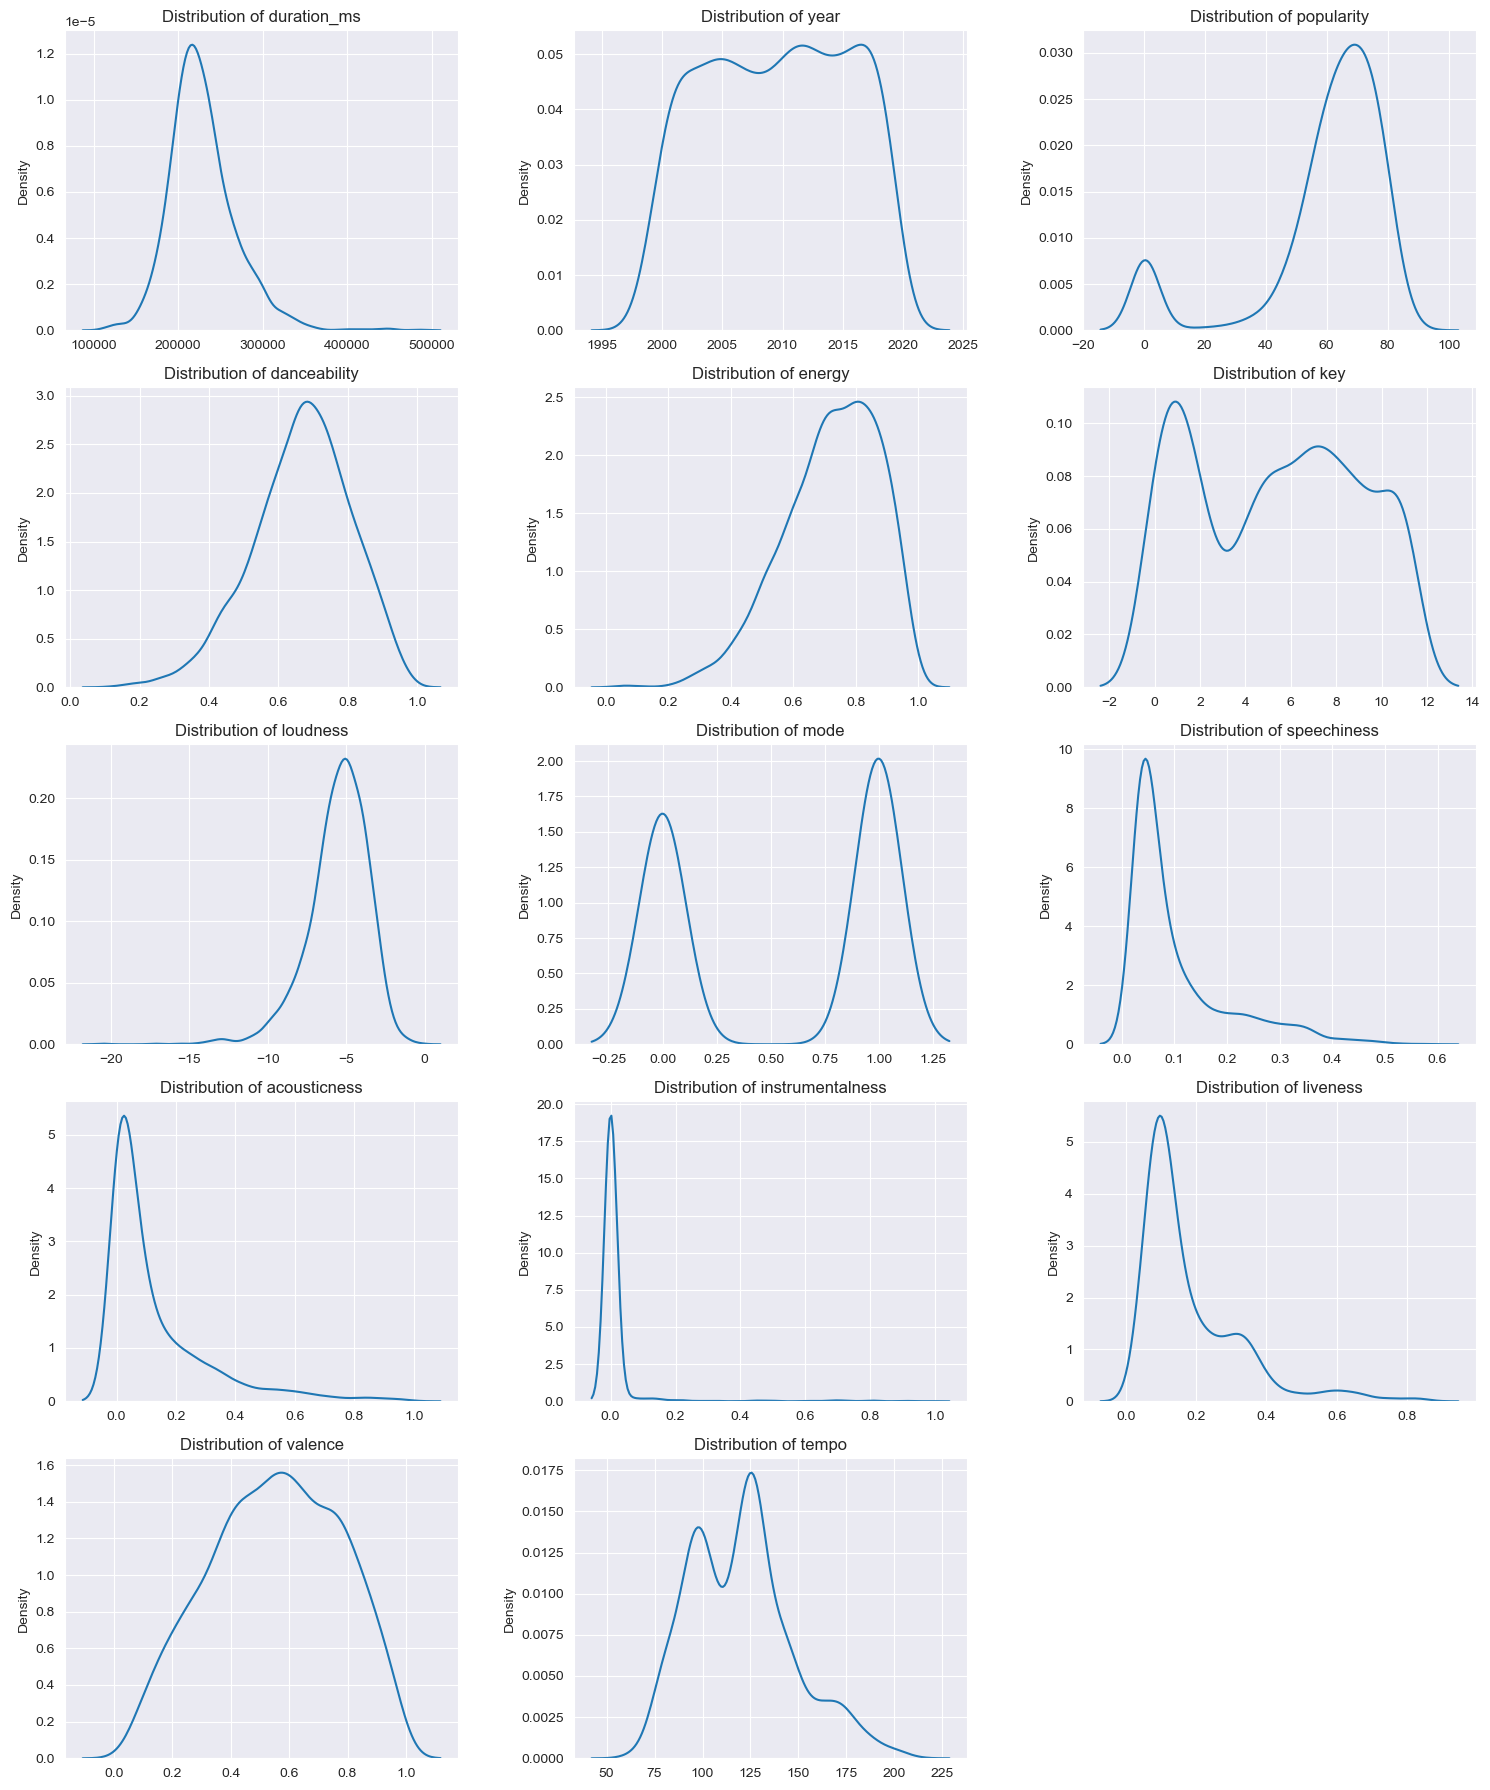

In [31]:
df_cont = df.select_dtypes([int,float])
fig = plt.figure(figsize=(15, 18))
for i,columns in enumerate(df_cont.columns, 1): 
    ax = plt.subplot(5,3,i)
    sns.kdeplot(x=df_cont[columns])
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {columns}')
    plt.tight_layout(w_pad=3)
plt.show()

In [32]:
df_cont = df.select_dtypes([int,float])
for i in df_cont.columns:
    print(f'Skewness in {i} =',df_cont[i].skew())

Skewness in duration_ms = 1.0231325405560865
Skewness in year = -0.05132846585197137
Skewness in popularity = -1.8016153651346538
Skewness in danceability = -0.4285315223442026
Skewness in energy = -0.6422206424295114
Skewness in key = -0.008848531690533078
Skewness in loudness = -1.2092136929521473
Skewness in mode = -0.21468143007083984
Skewness in speechiness = 1.7713042328315027
Skewness in acousticness = 2.1040573343657893
Skewness in instrumentalness = 7.564245407153093
Skewness in liveness = 1.836519998416987
Skewness in valence = -0.13560518442853997
Skewness in tempo = 0.5490029923831955


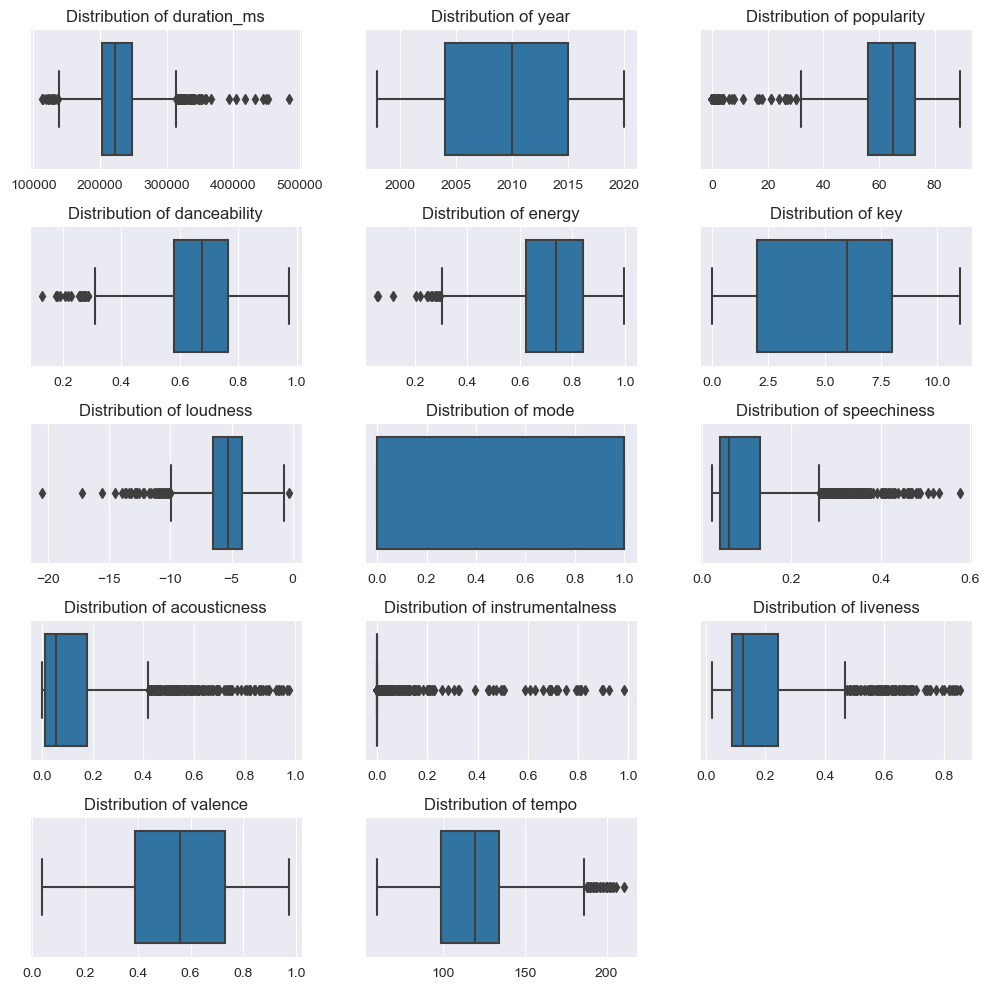

In [33]:
df_cont = df.select_dtypes([int,float])
fig = plt.figure(figsize=(10, 10))
for i,columns in enumerate(df_cont.columns, 1): 
    ax = plt.subplot(5,3,i)
    sns.boxplot(data = df_cont, x=df_cont[columns])
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {columns}')
    plt.tight_layout(w_pad=3)
plt.show()

In [34]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

In [35]:
popular_randb = df[df['genre'] == 'R&B'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_hiphop = df[df['genre'] == 'hip hop'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_pop = df[df['genre'] == 'pop'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_edm = df[df['genre'] == 'EDM'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_rock = df[df['genre'] == 'rock'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_metal = df[df['genre'] == 'metal'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_latin = df[df['genre'] == 'latin'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_folk = df[df['genre'] == 'acoustic folk'].sort_values('popularity', ascending=False)[features].iloc[0]
popular_country = df[df['genre'] == 'country'].sort_values('popularity', ascending=False)[features].iloc[0]

# radar_data = {
#     'features': features,
#     'values': popular_pop
# }
# radar_df = pd.DataFrame(radar_data)

In [36]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=popular_randb, theta=features, name='R&B'))
fig.add_trace(go.Scatterpolar(r=popular_hiphop, theta=features, name='Hip Hop'))
fig.add_trace(go.Scatterpolar(r=popular_pop, theta=features, name='Pop'))
fig.add_trace(go.Scatterpolar(r=popular_edm, theta=features, name='EDM'))
fig.add_trace(go.Scatterpolar(r=popular_rock, theta=features, name='Rock'))
fig.add_trace(go.Scatterpolar(r=popular_metal, theta=features, name='Metal'))
fig.add_trace(go.Scatterpolar(r=popular_latin, theta=features, name='Latin'))
fig.add_trace(go.Scatterpolar(r=popular_folk, theta=features, name='Folk'))
fig.add_trace(go.Scatterpolar(r=popular_country, theta=features, name='Country'))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True
)

fig.show()

### Machine Learning

In [37]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['genre'])
df['genre'] = encoded_labels
decoded_labels = label_encoder.inverse_transform(df['genre'])
print(encoded_labels)
print(decoded_labels)

[7 8 3 ... 4 7 4]
['pop' 'rock' 'country' ... 'hip hop' 'pop' 'hip hop']


In [38]:
# features = df.drop(columns=['artist', 'song', 'popularity', 'genre', 'explicit', 'key', 'mode', 
#                             'instrumentalness']).columns.tolist()
features = df.drop(['artist', 'song', 'popularity', 'genre', 'explicit', 'key', 'mode', 
                    'instrumentalness'], axis=1).columns.tolist()
# features = ['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']

In [39]:
X = df[features]
y = df['popularity']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [42]:
# from sklearn.decomposition import PCA 
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# explained_variance = pca.explained_variance_ratio_
# explained_variance

In [43]:
model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred)
mae_dt = mean_absolute_error(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print("Mean Squared Error:", mse_dt)
print("Mean Absolute Error:", mae_dt)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean Squared Error: 575.3469113056661
Mean Absolute Error: 16.336749515146987


In [44]:
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator.feature_importances_})
feature_df

Feature  Importance
0   duration_ms    0.095825
1          year    0.138957
2  danceability    0.039465
3        energy    0.088400
4      loudness    0.172516
5   speechiness    0.138921
6  acousticness    0.040162
7      liveness    0.068016
8       valence    0.129340
9         tempo    0.088399

In [45]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_rf)
print("Mean Absolute Error:", mae_rf)

with open('popularity_model.h5', 'wb') as file:
    pickle.dump(model, file)

Mean Squared Error: 488.54590671508134
Mean Absolute Error: 15.457694944301627


In [46]:
selector = SelectKBest(k='all')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse_k = mean_squared_error(y_test, y_pred)
mae_k = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_k)
print("Mean Absolute Error:", mae_k)

Mean Squared Error: 481.9811034643673
Mean Absolute Error: 15.441976435304198


In [47]:
selector = SelectFromModel(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                 max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
                                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                                 n_estimators=100, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                                 warm_start=False),
                          max_features=None, norm_order=1, prefit=False, threshold='median')

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(selected_features)

model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse_sfm = mean_squared_error(y_test, y_pred)
mae_sfm = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_sfm)
print("Mean Absolute Error:", mae_sfm)

Index(['duration_ms', 'energy', 'loudness', 'valence', 'tempo'], dtype='object')
Mean Squared Error: 520.972719227435
Mean Absolute Error: 16.29929005998286


In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred)
mae_linear = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_linear)
print("Mean Absolute Error:", mae_linear)

Mean Squared Error: 515.2787690619452
Mean Absolute Error: 15.368183982606034


In [49]:
model = BaggingRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse_bag = mean_squared_error(y_test, y_pred)
mae_bag = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_bag)
print("Mean Absolute Error:", mae_bag)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Squared Error: 490.93026392932927
Mean Absolute Error: 15.682013098298444
MAE: -15.493 (0.930)


In [50]:
model = AdaBoostRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_adaboost = mean_squared_error(y_test, y_pred)
mae_adaboost = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_adaboost)
print("Mean Absolute Error:", mae_adaboost)

Mean Squared Error: 512.4940467108385
Mean Absolute Error: 17.509654090795767


In [51]:
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_xgb)
print("Mean Absolute Error:", mae_xgb)

Mean Squared Error: 511.23180416640366
Mean Absolute Error: 15.944077538340748


In [52]:
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_gradient = mean_squared_error(y_test, y_pred)
mae_gradient = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse_gradient)
print("Mean Absolute Error:", mae_gradient)

Mean Squared Error: 502.81880542350683
Mean Absolute Error: 15.447220028763681


In [53]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42)
mlp.fit(X_train, y_train)
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)
m1 = mean_absolute_error(y_train, y_pred_train)
m2 = mean_absolute_error(y_test, y_pred_test)
print("MAE of MLP Regressor on training set: {:.3f}".format(m1))
print("MAE of MLP Regressor on test set: {:.3f}".format(m2))

MAE of MLP Regressor on training set: 14.896
MAE of MLP Regressor on test set: 15.460


In [54]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df

Actual  Predicted
1657       0  53.368095
1549       0  56.900460
70        55  52.470186
1008      72  61.310688
1086      74  55.499677
...      ...        ...
1596      77  57.731881
545       42  50.977060
629       68  61.774365
570       58  60.786575
1313      69  58.832939

[389 rows x 2 columns]

In [55]:
mae = [('Decision Tree', mae_dt),
       ('Random Forest', mae_rf),
       ('Select K Best', mae_k),
       ('Select From Model', mae_sfm),
       ('Linear Regression', mae_linear),
       ('Bagging', mae_bag),
       ('Ada Boost', mae_adaboost),
       ('XGBoost', mae_xgb),
       ('Gradient Boosting', mae_gradient),       
]

mae_df = pd.DataFrame(mae, columns=['Model', 'MAE'])
mae_df

Model        MAE
0      Decision Tree  16.336750
1      Random Forest  15.457695
2      Select K Best  15.441976
3  Select From Model  16.299290
4  Linear Regression  15.368184
5            Bagging  15.682013
6          Ada Boost  17.509654
7            XGBoost  15.944078
8  Gradient Boosting  15.447220

### Predict the Genre

In [56]:
label_df = pd.DataFrame({
    'genre': df['genre'],
    'label': decoded_labels
})

label_list = []
for i in label_df.values:
    label_list.append(i)
set(tuple(arr) for arr in label_list)

{(0, 'EDM'),
 (1, 'R&B'),
 (2, 'acoustic folk'),
 (3, 'country'),
 (4, 'hip hop'),
 (5, 'latin'),
 (6, 'metal'),
 (7, 'pop'),
 (8, 'rock')}

In [57]:
features = df.drop(['artist', 'song', 'popularity', 'genre', 'explicit', 'key', 'mode', 
                    'instrumentalness'], axis=1).columns.tolist()
# features = ['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']

In [58]:
X = df[features]
y = df['genre']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
                                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                                 n_estimators=100, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                                 warm_start=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

with open('genre_model.h5', 'wb') as file:
    pickle.dump(clf, file)

Accuracy: 0.43958868894601544


In [61]:
selector = SelectFromModel(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
                                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                                 n_estimators=100, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                                 warm_start=False),
                          max_features=None, norm_order=1, prefit=False, threshold='median')

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(selected_features)

model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Index(['duration_ms', 'danceability', 'energy', 'speechiness', 'tempo'], dtype='object')
Accuracy: 0.36503856041131105


In [62]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()  # Replace with your chosen model
num_features_to_keep = 5
rfe = RFE(model, n_features_to_select=num_features_to_keep)
rfe.fit(X_train, y_train)

selected_indices = rfe.get_support(indices=True)

selected_features = [features[i] for i in selected_indices]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print("Selected Features:", selected_features)
print("Accuracy:", accuracy)

Selected Features: ['duration_ms', 'danceability', 'speechiness', 'acousticness', 'tempo']
Accuracy: 0.32904884318766064


In [63]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load and prepare data
# Assuming you have X_train, X_test, y_train, y_test

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
y_pred_nn = model.predict(X_test_scaled)
y_pred_binary = (y_pred_nn > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)

print("Test Accuracy:", accuracy)

Epoch 1/100
39/39 [==============================] - 1s 7ms/step - loss: -1.3966 - accuracy: 0.2313 - val_loss: -4.9648 - val_accuracy: 0.1961
Epoch 2/100
39/39 [==============================] - 0s 2ms/step - loss: -10.2243 - accuracy: 0.2305 - val_loss: -18.3400 - val_accuracy: 0.1961
Epoch 3/100
39/39 [==============================] - 0s 2ms/step - loss: -30.2041 - accuracy: 0.2305 - val_loss: -48.0336 - val_accuracy: 0.1961
Epoch 4/100
39/39 [==============================] - 0s 2ms/step - loss: -74.3264 - accuracy: 0.2305 - val_loss: -108.2734 - val_accuracy: 0.1961
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: -157.4921 - accuracy: 0.2305 - val_loss: -216.9139 - val_accuracy: 0.1961
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: -298.3699 - accuracy: 0.2305 - val_loss: -386.1316 - val_accuracy: 0.1961
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: -513.1398 - accuracy: 0.2305 - val_loss: -636.6945 - v

39/39 [==============================] - 0s 3ms/step - loss: -315693.0000 - accuracy: 0.2305 - val_loss: -300086.5938 - val_accuracy: 0.1961
Epoch 56/100
39/39 [==============================] - 0s 2ms/step - loss: -331365.5000 - accuracy: 0.2305 - val_loss: -314789.3438 - val_accuracy: 0.1961
Epoch 57/100
39/39 [==============================] - 0s 2ms/step - loss: -347535.8438 - accuracy: 0.2305 - val_loss: -329848.0625 - val_accuracy: 0.1961
Epoch 58/100
39/39 [==============================] - 0s 2ms/step - loss: -364028.4062 - accuracy: 0.2305 - val_loss: -345687.6875 - val_accuracy: 0.1961
Epoch 59/100
39/39 [==============================] - 0s 3ms/step - loss: -381150.4062 - accuracy: 0.2305 - val_loss: -361556.3750 - val_accuracy: 0.1961
Epoch 60/100
39/39 [==============================] - 0s 3ms/step - loss: -398716.4375 - accuracy: 0.2305 - val_loss: -377607.2188 - val_accuracy: 0.1961
Epoch 61/100
39/39 [==============================] - 0s 3ms/step - loss: -416532.7812 - 

In [64]:
genre_prediction = clf.predict([df[df['artist'] == 'Marshmello'][features].iloc[1]])
label_encoder.inverse_transform(genre_prediction)

array(['EDM'], dtype=object)

In [65]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df

Actual  Predicted
1657       0          0
1549       4          7
70         1          4
1008       7          1
1086       4          1
...      ...        ...
1596       7          7
545        7          7
629        4          1
570        8          7
1313       4          0

[389 rows x 2 columns]

### Streamlit Application

In [66]:
%%writefile app.py

import streamlit as st
import streamlit.components.v1 as components

import pickle

with open('genre_model.h5', 'rb') as genre_file:
    genre_model = pickle.load(genre_file)

with open('popularity_model.h5', 'rb') as model_file:
    model = pickle.load(model_file)
    
labels = [
    {'Genre': 'EDM', 'Label': 0},
    {'Genre': 'R&B', 'Label': 1},
    {'Genre': 'Acoustic Folk', 'Label': 2},
    {'Genre': 'Country', 'Label': 3},
    {'Genre': 'Hip Hop', 'Label': 4},
    {'Genre': 'Latin', 'Label': 5},
    {'Genre': 'Metal', 'Label': 6},
    {'Genre': 'Pop', 'Label': 7},
    {'Genre': 'Rock', 'Label': 8},
]
    
def predict_genre(danceability, energy, speechiness, acousticness, liveness, valence):
    """
    this method is for predicting genre
    takes all the Audio characteristics that we used for modelling and returns the prediction 
    """
    prediction = genre_model.predict([[danceability, energy, speechiness, acousticness, liveness, valence]])
    return prediction[0]

def predict_popularity(danceability, energy, speechiness, acousticness, liveness, valence):
    """
    this method is for predicting popularity
    takes all the Audio characteristics that we used for modelling and returns the prediction 
    """
    prediction = model.predict([[danceability, energy, speechiness, acousticness, liveness, valence]])
    return prediction[0]

def main():
    st.title("Data Analysis Project")
    
#     st.image("https://cdn2.downdetector.com/static/uploads/logo/Spotify_Logo_RGB_Green.png", width=700, use_column_width=False)
    st.image("https://cdn.dribbble.com/users/441326/screenshots/3165191/spotify-gif---oliver-keane.gif", 
             width=700, use_column_width=False)
     
    html_temp2 = """
        <div style="background-color:limegreen; padding:10px;border-radius:10px;">
        <h1 style="color:white;text-align:center;">Predict the Song's Popularity on Spotify</h1>
        </div>
        """
    # can use st.write()
    components.html(html_temp2)
    # components.html() will render the render the html component
        
    danceability = st.slider("danceability", min_value=0.00, max_value=1.00, step=0.05)
    energy = st.slider("energy", min_value=0.00, max_value=1.00, step=0.05)
    speechiness = st.slider("speechiness", min_value=0.00, max_value=1.00, step=0.05)
    acousticness = st.slider("acousticness", min_value=0.00, max_value=1.00, step=0.05)
    liveness = st.slider("liveness", min_value=0.00, max_value=1.00, step=0.05)
    valence = st.slider("valence", min_value=0.00, max_value=1.00, step=0.05)
    
    genre=""
    result=""
    if st.button("Predict"):
#         st.table(labels)
        genre = predict_genre(danceability, energy, speechiness, acousticness, liveness, valence)
        result = predict_popularity(danceability, energy, speechiness, acousticness, liveness, valence)
        
        for item in labels:
            if item['Label'] == genre:
                genre = item['Genre']
                break
            else:
                print('Label not found')

        st.success("The song's genre is {}".format(genre))
        st.success('The Popularity of the song is {}'.format(result))

if __name__=='__main__':
    main()

Overwriting app.py
